In [12]:
import pickle
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

### Preprocessing

In [2]:
raw_data = pd.read_csv("../../data_clean.csv")
data = raw_data[raw_data['birth date'] < 2020].copy()

data['age'] = data['parole board interview date'] - data['birth date']
data['jail duration'] = data['parole board interview date'] - data['year of entry']

others_parole_type =  ['PIE', 'SP CONSDR', 'ECPDO', 'MEDICAL','RESCISSION', 'DEPORT']
data['parole board interview type'] = data['parole board interview type'].replace(others_parole_type, 'OTHERS').replace('SUPP MERIT', 'MERIT TIME').replace('PV REAPP', 'REAPPEAR')

data = data.dropna(axis=0, subset=['crime 1 - class', 'parole eligibility date'])

df_one_hot = pd.get_dummies(data, columns=[
    "sex", "race / ethnicity"], drop_first=True)

df_one_hot = pd.get_dummies(df_one_hot, columns=[
    "crime 1 - class", "crime 2 - class",
    "crime 3 - class", "crime 4 - class",
    "parole board interview type"])

df_one_hot.drop(columns=['release date','birth date', 'year of entry'],inplace=True)

X_train, X_test, y_train, y_test = train_test_split(df_one_hot.drop('y',axis=1), df_one_hot['y'], 
                                                    stratify=df_one_hot['y'], test_size=0.3, random_state=42)

### Loading black box model

In [3]:
# Load the model from the .pkl file
xgb_classifier = pickle.load(open("../model.pkl", "rb"))

In [4]:
xgb_classifier

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### Predicting on the training dataset

In [5]:
blackbox_predictions = xgb_classifier.predict(X_train)

### Surrogate model

In [7]:
dt_classifier = DecisionTreeClassifier(max_depth=3)
dt_classifier.fit(X_train, blackbox_predictions)

dt_predictions = dt_classifier.predict(X_train)

In [11]:
# Calculate evaluation metrics
train_accuracy = accuracy_score(blackbox_predictions, dt_predictions)
train_roc_auc = roc_auc_score(blackbox_predictions, dt_predictions)
train_f1 = f1_score(blackbox_predictions, dt_predictions)

# Print the evaluation metrics
print("How capable is the surrogate model when it comes to predicting the outputs of the black box model?")
print(f"Accuracy: {train_accuracy:.2f}")
print(f"ROC AUC: {train_roc_auc:.2f}")
print(f"F1 Score: {train_f1:.2f}")

How capable is the surrogate model when it comes to predicting the outputs of the black box model?
Accuracy: 0.84
ROC AUC: 0.84
F1 Score: 0.81


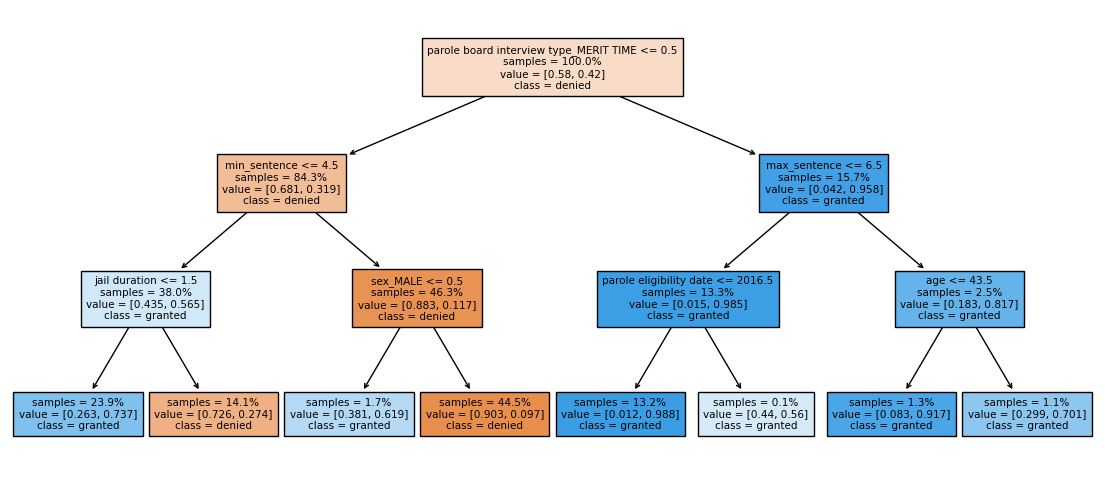

In [13]:
plt.figure(figsize=(14, 6))
tree = plot_tree(dt_classifier, feature_names=X_train.columns, class_names=['denied', 'granted'], filled=True, impurity=False, fontsize=7.5, proportion=True)
plt.show()